Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

    - what are the characteristics and behaviours that have the strongest correlation with subscribing

Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.

    - within the people who subscribed, what are the portfolios of the players?

Question 3: We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. 

    - graph histogram 

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


**1. Data description**
- Provide a full descriptive summary of the dataset, including 
(1) information such as the **number of observations**, **summary statistics** (report values to 2 decimal places), **number of variables**, **name and type of variables**, what the **variables mean**
(2) any **issues** you see in the data, any other potential issues related to things you cannot directly see, how the data were collected, etc. Make sure to use bullet point lists or tables to summarize the variables in an easy-to-understand format.

Note that the selected dataset(s) will probably contain more variables than you need. In fact, exploring how the different variables in the dataset affect your model may be a crucial part of the project. You need to summarize the full data regardless of which variables you may choose to use later on.

In [2]:
player_data <- read_csv("data/players.csv")
session_data <- read_csv("data/sessions.csv")
joined_data <- player_data |> left_join(session_data) |> group_by(hashedEmail) |> summarize(count = n())
summary_statistics_age <- player_data |> summarize(mean = mean(Age, na.rm = TRUE), max = max(Age, na.rm = TRUE), min = min(Age, na.rm = TRUE)) 

summary_statistics_hours1 <- player_data |> summarize(mean = mean(played_hours, na.rm = TRUE)) 
summary_statistics_hours2 <- player_data |> summarize(max = max(played_hours, na.rm = TRUE), min = min(played_hours, na.rm = TRUE)) 
summary_statistics_hours <- bind_cols(summary_statistics_hours1, summary_statistics_hours2)

summary_statistics_log <- joined_data |> summarize(mean = mean(count), max = max(count), min = min(count))

measure <- c("age", "played hours", "log times")

summary_statistics <- bind_rows(summary_statistics_age, summary_statistics_hours, summary_statistics_log) |> add_column(measure) |> relocate(measure, .before = mean)

summary_statistics

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(hashedEmail)`


measure,mean,max,min
<chr>,<dbl>,<dbl>,<dbl>
age,21.139175,58.0,9
played hours,5.845918,223.1,0
log times,8.193878,310.0,1


- Number of observations: There are 196 observations (players), as seen by the number of rows in the players.csv file. 
- Summary statistics: the average age of players in the game is around 21 years old, they usually played around 6 hours, and logged onto the game around 8 times.
The oldest player in the game is 58 years old. The player who spent the most time on the game spent 223.1 hours, and the player who logged in the most times logged onto the game 310 times (1 log is 1 session).
The youngest player in the game is 9 years old. The player who spent the minimum time on the game spent 0 hours, and the player who logged in the least amount of times logged onto the game once.
- name and type of variables: in the players.csv, there are 7 variables (Age, hashedEmail, name, subscribe, experience, played_hours, and gender). Each variable is a characteristic of a player: their age, their email, name, level of experience, gender, their played hours, and whether or not they are subscribed to the newsletter. In the sessions.csv, there are 5 variables (hashedEmail, start_time, end_time, original_start_time, original_end_time). Each variable is a characteristic of a session: the player in the session, the start time and end time of the session, and the original start and end time of that session. 
- Some issues that arise are that there are NA values, for example, in Age, meaning the research group is not able to collect all the details of all players. Another thing is how "player" is defined, whether one is considered a player when making an account, or a player when they start to play. Many players have 0 hours of playtime, and whether or not they are taken into consideration is important because this changes the value of the average time spent on the game dramatically (if they are considered, the mean is around 6 hours, and if they aren't, the mean is around 10 hours). A final issue could be related to ethics, in terms of how the research group may use this collected data without breaching the privacy of their players. 

**2. Question**
- Clearly state **one broad question** that you will address, and the **specific question** that you have formulated. Your question should involve **one response variable of interest and one or more explanatory variables**, and should be stated as a question. One common question format is: “Can [explanatory variable(s)] predict [response variable] in [dataset]?”, but you are free to format your question as you choose so long as it is clear. **Describe** clearly how the data will help you address the question of interest. You may need to describe how you plan to wrangle your data to get it into a form where you can apply one of the predictive methods from this class.

- I will be choosing question 2: which "kinds" of players are most likely to contribute a large amount of data? 
- Therefore, my specific question will be: which group of age and level of experience are most represented in the datasets? 
- The data will help me address my question because (1) for the level of experience, I plan to use group_by() + summarize() to count the number of players with different levels of experience and also visualize it through a barplot (2) for the group of age, I plan to plot a histogram to visualize the mode and therefore see which group of age contributes the most to the large amount of data. 

**3. Exploratory data analysis and visualization**
- In this assignment, you will: Demonstrate that the dataset can be loaded into R.
- Do the minimum necessary wrangling to **turn your data into a tidy format**. Do not do any additional wrangling here; that will happen later during the group project phase.
- Compute the **mean value for each quantitative variable in the players.csv data set**. Report the mean values in a table format. Make a few exploratory visualizations of the data to help you understand it.
- Use our visualization best practices to make **high-quality plots** (make sure to include labels, titles, units of measurement, etc)
- **Explain any insights** you gain from these plots that are relevant to address your question
Note: do not perform any predictive analysis here. We are asking for an exploration of the relevant variables to demonstrate that you understand them well before performing any additional modelling, and to identify potential problems you anticipate encountering.

measure,mean,max,min
<chr>,<dbl>,<dbl>,<dbl>
age,21.139175,58.0,9
played hours,5.845918,223.1,0


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_bar()`).”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 85 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 9 rows containing missing values or values outside the scale range
(`geom_bar()`).”


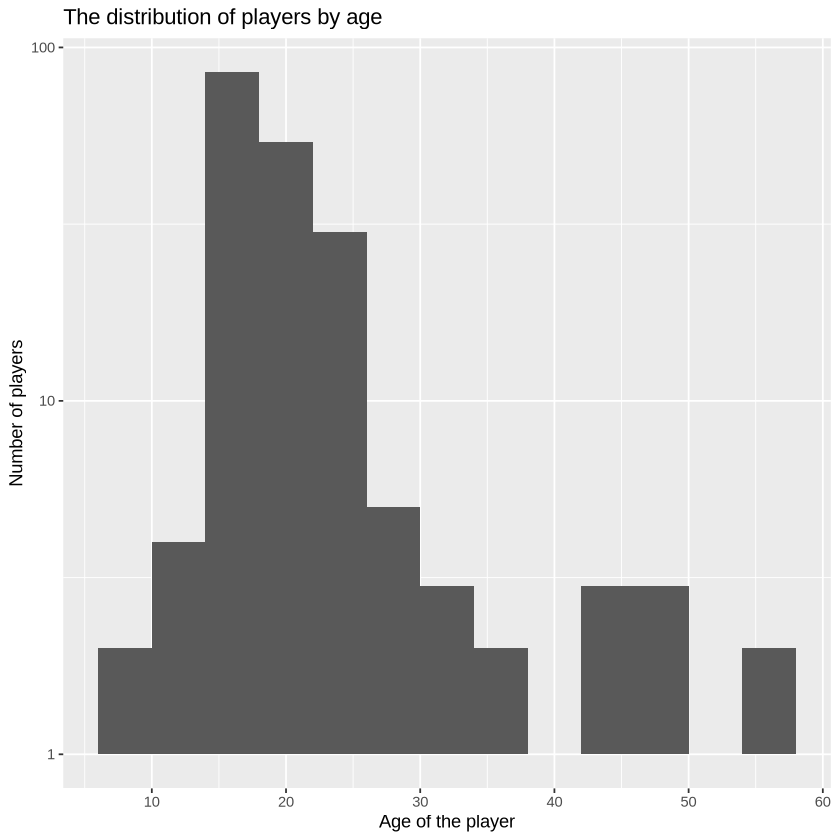

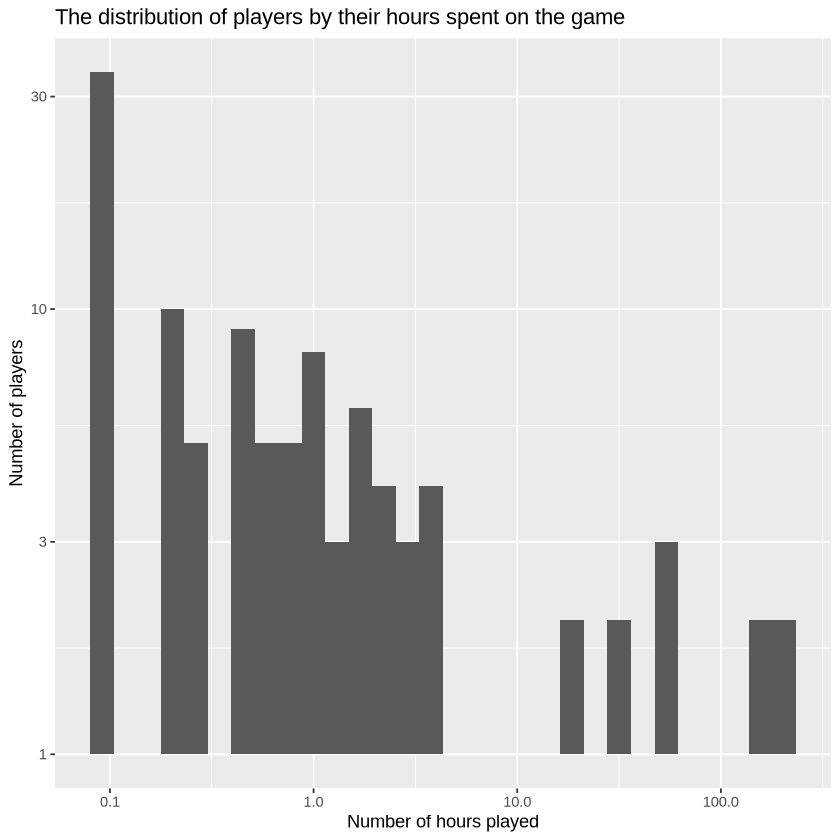

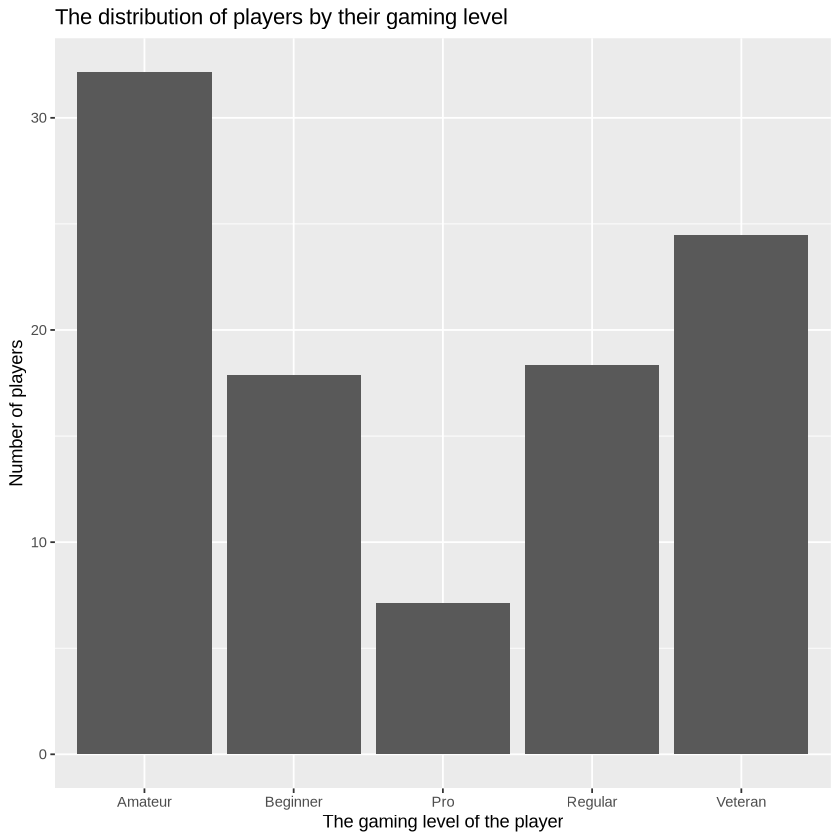

In [3]:
summary_statistics_3 <- summary_statistics |> filter(measure %in% c("played hours" , "age"))
summary_statistics_3
plot_for_age <- player_data |> ggplot(aes(x = Age)) + geom_histogram(binwidth = 4, position = "stack") + scale_y_log10() + labs(x = "Age of the player", y = "Number of players", title = "The distribution of players by age")
plot_for_age

plot_for_played_hours <- player_data |> ggplot(aes(x = played_hours)) + geom_histogram() + scale_x_log10() + scale_y_log10() + labs(x = "Number of hours played", y = "Number of players", title = "The distribution of players by their hours spent on the game")
plot_for_played_hours

plot_for_experience <- player_data |> group_by(experience) |> summarize(count = n()) |> mutate(percentage = count/196*100) |> 
ggplot(aes(x = experience, y = percentage)) + geom_bar(stat = "identity") + labs(x = "The gaming level of the player", y = "Number of players", title = "The distribution of players by their gaming level")
plot_for_experience

**4. method and plan**

**5. github repository**